# Importing Libraries

In [1]:
import numpy as np, pandas as pd

import re
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
import string
from string import ascii_lowercase

from tqdm import tqdm_notebook
import itertools
import io

import matplotlib.pyplot as plt
%matplotlib inline

from functools import reduce
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import BatchNormalization
from keras import initializers, regularizers, constraints, optimizers, layers
import talos

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Importing Data

In [2]:
train = pd.read_csv('./datasetToxic - copy/train.csv.zip')
test = pd.read_csv('./datasetToxic - copy/test.csv.zip') 

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


# Data Exploration

Checking for missing values

In [5]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [6]:
test.isnull().any()


id              False
comment_text    False
dtype: bool

In [7]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[labels].values

#Data Pre-processing

## Text Normalization

* Removing Characters in between Text
* Removing Repeated Characters
* Converting data to lower-case
* Removing Numbers from the data
* Remove Punctuation
* Remove Whitespaces
* Removing spaces in between words
* Removing "\n"
* Remove Non-english characters

In [8]:
RE_PATTERNS = {
    ' american ':
        [
            'amerikan'
        ],

    ' adolf ':
        [
            'adolf'
        ],


    ' hitler ':
        [
            'hitler'
        ],

    ' fuck':
        [
            '(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            '(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)',
            ' f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f u u c',
            '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',
            'feck ', ' fux ', 'f\*\*', 'f**k','fu*k',
            'f\-ing', 'f\.u\.', 'f###', ' fu ', 'f@ck', 'f u c k', 'f uck', 'f ck'
        ],

    ' ass ':
        [
            '[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$',
            '[^a-z]anus', ' a\*s\*s', '[^a-z]ass[^a-z ]',
            'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s','a55', '@$$'
        ],

    ' ass hole ':
        [
            ' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole', 'a**hole'
        ],

    ' bitch ':
        [
            'b[w]*i[t]*ch', 'b!tch',
            'bi\+ch', 'b!\+ch', '(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)',
            'biatch', 'bi\*\*h', 'bytch', 'b i t c h', 'b!tch', 'bi+ch', 'l3itch'
        ],

    ' bastard ':
        [
            'ba[s|z]+t[e|a]+rd'
        ],

    ' trans gender':
        [
            'transgender'
        ],

    ' gay ':
        [
            'gay'
        ],

    ' cock ':
        [
            '[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'
        ],

    ' dick ':
        [
            ' dick[^aeiou]', 'deek', 'd i c k', 'dik'
        ],

    ' suck ':
        [
            'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'
        ],

    ' cunt ':
        [
            'cunt', 'c u n t'
        ],

    ' bull shit ':
        [
            'bullsh\*t', 'bull\$hit'
        ],

    ' homo sex ual':
        [
            'homosexual'
        ],

    ' jerk ':
        [
            'jerk'
        ],

    ' idiot ':
        [
            'i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)', 'idiots'
                                                                                      'i d i o t'
        ],

    ' dumb ':
        [
            '(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'
        ],

    ' shit ':
        [
            'shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t', '$h1t'
        ],

    ' shit hole ':
        [
            'shythole'
        ],

    ' retard ':
        [
            'returd', 'retad', 'retard', 'wiktard', 'wikitud'
        ],

    ' rape ':
        [
            ' raped'
        ],

    ' dumb ass':
        [
            'dumbass', 'dubass'
        ],

    ' ass head':
        [
            'butthead'
        ],

    ' sex ':
        [
            'sexy', 's3x', 'sexuality'
        ],


    ' nigger ':
        [
            'nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'
        ],

    ' shut the fuck up':
        [
            'stfu', 'st*u'
        ],

    ' pussy ':
        [
            'pussy[^c]', 'pusy', 'pussi[^l]', 'pusses', 'p*ssy'
        ],

    ' faggot ':
        [
            'faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',
        ],

    ' mother fucker':
        [
            ' motha ', ' motha f', ' mother f', 'motherucker',
        ],

    ' whore ':
        [
            'wh\*\*\*', 'w h o r e'
        ],
    ' fucking ':
        [
            'f*$%-ing'
        ],
}


In [9]:
def clean_text(text,remove_repeat_text=True, remove_patterns_text=True, is_lower=True):

  if is_lower:
    text=text.lower()
    
  if remove_patterns_text:
    for target, patterns in RE_PATTERNS.items():
      for pat in patterns:
        text=str(text).replace(pat, target)

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text) 

  text = str(text).replace("\n", " ")
  text = re.sub(r'[^\w\s]',' ',text)
  text = re.sub('[0-9]',"",text)
  text = re.sub(" +", " ", text)
  text = re.sub("([^\x00-\x7F])+"," ",text)
  return text 

Cleaning Training Data

In [10]:
train['comment_text']=train['comment_text'].apply(lambda x: clean_text(x))
train['comment_text'][1]

'd aww he matches this background colour i m seemingly stuck with thanks talk january utc '

Cleaning Test Data

In [11]:
test['comment_text']=test['comment_text'].apply(lambda x: clean_text(x))
test['comment_text'][1]

' from rfc the title is fine as it is imo '

## Lemmatization

In [12]:
comments_train=train['comment_text']
comments_test=test['comment_text']

In [13]:
comments_train=list(comments_train)
comments_test=list(comments_test)

In [14]:
wordnet_lemmatizer = WordNetLemmatizer()

In [15]:
def lemma(text, lemmatization=True):
  output=""
  if lemmatization:
    text=text.split(" ")
    for word in text:
       word1 = wordnet_lemmatizer.lemmatize(word, pos = "n")
       word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
       word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a")
       word4 = wordnet_lemmatizer.lemmatize(word3, pos = "r")
       output=output + " " + word4
  else:
    output=text
  
  return str(output.strip()) 

Lemmatizing Training Data

In [16]:
lemmatized_train_data = [] 

for line in tqdm_notebook(comments_train, total=30000): 
    lemmatized_train_data.append(lemma(line))

  0%|          | 0/30000 [00:00<?, ?it/s]

In [17]:
lemmatized_train_data[50000]

'go fuck yourself allahu akbar'

Lemmatizing Test Data

In [18]:
lemmatized_test_data = [] 

for line in tqdm_notebook(comments_test, total=30000): 
    lemmatized_test_data.append(lemma(line))

  0%|          | 0/30000 [00:00<?, ?it/s]

## Stopwords Removal

In [19]:
stopword_list=STOP_WORDS

Adding Single and Dual to STOP_WORDS

In [20]:
def iter_all_strings():
    for size in itertools.count(1):
        for s in itertools.product(ascii_lowercase, repeat=size):
            yield "".join(s)

dual_alpha_list=[]
for s in iter_all_strings():
    dual_alpha_list.append(s)
    if s == 'zz':
        break

In [21]:
dual_alpha_list.remove('i')
dual_alpha_list.remove('a')
dual_alpha_list.remove('am')
dual_alpha_list.remove('an')
dual_alpha_list.remove('as')
dual_alpha_list.remove('at')
dual_alpha_list.remove('be')
dual_alpha_list.remove('by')
dual_alpha_list.remove('do')
dual_alpha_list.remove('go')
dual_alpha_list.remove('he')
dual_alpha_list.remove('hi')
dual_alpha_list.remove('if')
dual_alpha_list.remove('is')
dual_alpha_list.remove('in')
dual_alpha_list.remove('me')
dual_alpha_list.remove('my')
dual_alpha_list.remove('no')
dual_alpha_list.remove('of')
dual_alpha_list.remove('on')
dual_alpha_list.remove('or')
dual_alpha_list.remove('ok')
dual_alpha_list.remove('so')
dual_alpha_list.remove('to')
dual_alpha_list.remove('up')
dual_alpha_list.remove('us')
dual_alpha_list.remove('we')

In [22]:
for letter in dual_alpha_list:
    stopword_list.add(letter)
print("Done!!")

Done!!


Checking for other words that we may need in STOP_WORDS

In [23]:
def search_stopwords(data, search_stop=True):
  output=""
  if search_stop:
    data=data.split(" ")
    for word in data:
      if not word in stopword_list:
        output=output+" "+word 
  else:
    output=data

  return str(output.strip())  

In [24]:
potential_stopwords = [] 

for line in tqdm_notebook(lemmatized_train_data, total=30000): 
    potential_stopwords.append(search_stopwords(line))

  0%|          | 0/30000 [00:00<?, ?it/s]

In [25]:
len(potential_stopwords)

159571

Combining all the sentences in the list into a single string

In [26]:
def string_combine_a(stopword):
  final_a=""
  for item in range(12500):
    final_a=final_a+" "+stopword[item]
  return final_a

def string_combine_b(stopword):
  final_b=""
  for item in range(12500,25000):
    final_b=final_b+" "+stopword[item]
  return final_b

def string_combine_c(stopword):
  final_c=""
  for item in range(25000,37500):
    final_c=final_c+" "+stopword[item]
  return final_c

def string_combine_d(stopword):
  final_d=""
  for item in range(37500,50000):
    final_d=final_d+" "+stopword[item]
  return final_d

In [27]:
total_string_potential_a=string_combine_a(potential_stopwords)
total_string_potential_b=string_combine_b(potential_stopwords)
total_string_potential_c=string_combine_c(potential_stopwords)
total_string_potential_d=string_combine_d(potential_stopwords)

Counting the number of words in each of the 4 strings

In [28]:
def word_count(str):
    counts = dict()
    words = str.split()

    for word in words:
        if word in counts:
            counts[word] += 1
        else:
            counts[word] = 1

    return counts

In [29]:
total_string_potential_a_dict=word_count(total_string_potential_a)
total_string_potential_b_dict=word_count(total_string_potential_b)
total_string_potential_c_dict=word_count(total_string_potential_c)
total_string_potential_d_dict=word_count(total_string_potential_d)

Converting Dictionaries to Dataframe

In [30]:
total_string_potential_a_df = pd.DataFrame(list(total_string_potential_a_dict.items()),columns = ['Word','Count'])
total_string_potential_b_df = pd.DataFrame(list(total_string_potential_b_dict.items()),columns = ['Word','Count'])
total_string_potential_c_df = pd.DataFrame(list(total_string_potential_c_dict.items()),columns = ['Word','Count'])
total_string_potential_d_df = pd.DataFrame(list(total_string_potential_d_dict.items()),columns = ['Word','Count'])

Getting Dataframe output in descending order

In [31]:
top50_potential_stopwords_a=total_string_potential_a_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_b=total_string_potential_b_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_c=total_string_potential_c_df.sort_values(by=['Count'],ascending=False).head(50)
top50_potential_stopwords_d=total_string_potential_d_df.sort_values(by=['Count'],ascending=False).head(50)

Looking for common terms in all top 50 dataframes

In [32]:
common_potential_stopwords=list(reduce(set.intersection,map(set,[top50_potential_stopwords_a.Word,top50_potential_stopwords_b.Word,top50_potential_stopwords_c.Word,top50_potential_stopwords_d.Word])))

In [33]:
print(common_potential_stopwords)

['people', 'link', 'user', 'find', 'information', 'want', 'work', 'list', 'block', 'editor', 'help', 'section', 'don', 'question', 'change', 'good', 'comment', 'way', 'try', 'point', 'delete', 'thank', 'edit', 'talk', 'look', 'thing', 'read', 'source', 'article', 'image', 'page', 'like', 'know', 'remove', 'time', 'need', 'doe', 'deletion', 'use', 'wikipedia', 'add', 'think', 'new', 'write']


Retaining certain words and removing others from the above list

In [34]:
potential_stopwords=['editor', 'reference', 'thank', 'work','find', 'good', 'know', 'like', 'look', 'thing', 'want', 'time', 'list', 'section','wikipedia', 'doe', 'add','new', 'try', 'think', 'write','use', 'user', 'way', 'page']

Adding above retrived words into the stopwords list

In [35]:
for word in potential_stopwords:
    stopword_list.add(word)
print("Done!!")

Done!!


Removing Stopwords from Training Data

In [36]:
def remove_stopwords(text, remove_stop=True):
  output = ""
  if remove_stop:
    text=text.split(" ")
    for word in text:
      if word not in stopword_list:
        output=output + " " + word
  else :
    output=text

  return str(output.strip())      

In [37]:
processed_train_data = [] 

for line in tqdm_notebook(lemmatized_train_data, total=50000): 
    processed_train_data.append(remove_stopwords(line))

  0%|          | 0/50000 [00:00<?, ?it/s]

In [38]:
processed_train_data[50000]

'fuck allahu akbar'

Removing Stopwords from Test Data

In [39]:
processed_test_data = [] 

for line in tqdm_notebook(lemmatized_test_data, total=50000): 
    processed_test_data.append(remove_stopwords(line))

  0%|          | 0/50000 [00:00<?, ?it/s]

# Model Building

In [40]:
max_features=100000      
maxpadlen = 200          
val_split = 0.2      
embedding_dim_fasttext = 300

Tokenization

In [41]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(processed_train_data))
list_tokenized_train = tokenizer.texts_to_sequences(processed_train_data)
list_tokenized_test = tokenizer.texts_to_sequences(processed_test_data)

In [42]:
word_index=tokenizer.word_index
print("Words in Vocabulary: ",len(word_index))

Words in Vocabulary:  148917


Padding

In [43]:
X_t=pad_sequences(list_tokenized_train, maxlen=maxpadlen, padding = 'post')
X_te=pad_sequences(list_tokenized_test, maxlen=maxpadlen, padding = 'post')

In [44]:
print('Tokenized sentences: \n', X_t[10])
print('One hot label: \n', y[10])

Tokenized sentences: 
 [  116   578    11 32199   239   192    11 32199   239    90    11   579
    11   116   366   578     1  1082   116   338  5356   116   119    11
   387   269   366   578    11     1  1341   116    11   387     2    32
   116   578   192   116   172    46    84   579   116   578    11     2
   488   105    10  1087   403  1073    11  2401   489    36   116    11
   192   407   366     9   255   192   242   150   109    18    19    29
   172    77    19     3   257  4540     4    11 32199   239   192    11
 32199   239    90   171   387   312    68   579    34    44    77   423
  1550    34   171     8   579  1268    77  1638   134    10   134  4671
   134    94    44   565  1255    17    77  1338   118   134  1577    77
  1134     4   507    77   434    31   171    68    34   168  2207   449
    31   315  1529    70   172   236   150   116    31    31    11    77
    31   116    11    77    31    77    31   192   171    46    84   579
     4    31   171   192    

In [45]:
indices = np.arange(X_t.shape[0])
np.random.shuffle(indices)

In [46]:
X_t = X_t[indices]
labels = y[indices]

### Splitting data into Training and Validation Set

In [47]:
num_validation_samples = int(val_split*X_t.shape[0])
x_train = X_t[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = X_t[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]

In [48]:
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [12272  1280  6738   368  6308  1146]
validation:  [3022  315 1711  110 1569  259]


### Importing Fast Text

In [49]:
embeddings_index_fasttext = {}
f = open('./wiki-news-300d-1M.vec', encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index_fasttext[word] = np.asarray(values[1:], dtype='float32')
f.close()

In [50]:
embedding_matrix_fasttext = np.random.random((len(word_index) + 1, embedding_dim_fasttext))
for word, i in word_index.items():
    embedding_vector = embeddings_index_fasttext.get(word)
    if embedding_vector is not None:
        embedding_matrix_fasttext[i] = embedding_vector
print(" Completed!")

 Completed!


### Creating Model

#### Talos Grid Search  for LSTM Model

In [51]:
def toxic_classifier(x_train,y_train,x_val,y_val,params):

  inp=Input(shape=(maxpadlen, ),dtype='int32')

  embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
  embedded_sequences = embedding_layer(inp)

  x = LSTM(params['output_count_lstm'], return_sequences=True,name='lstm_layer')(embedded_sequences)
  
  x = GlobalMaxPool1D()(x)
  
  x = Dropout(params['dropout'])(x)
  
  x = Dense(params['output_count_dense'], activation=params['activation'], kernel_initializer='he_uniform')(x)
  
  x = Dropout(params['dropout'])(x)
  
  preds = Dense(6, activation=params['last_activation'], kernel_initializer='glorot_uniform')(x)

  model = Model(inputs=inp, outputs=preds)

  model.compile(loss=params['loss'], optimizer=params['optimizer'], metrics=['accuracy'])

  model_info=model.fit(x_train,y_train, epochs=params['epochs'], batch_size=params['batch_size'],  validation_data=(x_val, y_val))

  return model_info, model

In [52]:
p={
    'output_count_lstm': [40,50,60],
    'output_count_dense': [30,40,50],
    'batch_size': [32],
    'epochs':[2],
    'optimizer':['adam'],
    'activation':['relu'],
    'last_activation': ['sigmoid'],
    'dropout':[0.1,0.2],
    'loss': ['binary_crossentropy']   
}

In [53]:
scan_results = talos.Scan(x=x_train,
               y=y_train,
               x_val=x_val,
               y_val=y_val,
               model=toxic_classifier,
               params=p,
               experiment_name='tcc',
               print_params=True)

  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

{'output_count_lstm': 40, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 421s 104ms/step - loss: 0.0677 - accuracy: 0.8837 - val_loss: 0.0501 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 429s 107ms/step - loss: 0.0504 - accuracy: 0.9845 - val_loss: 0.0476 - val_accuracy: 0.9941


  6%|████▍                                                                           | 1/18 [14:12<4:01:40, 852.96s/it]

{'output_count_lstm': 40, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 451s 112ms/step - loss: 0.0666 - accuracy: 0.9382 - val_loss: 0.0512 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 463s 116ms/step - loss: 0.0524 - accuracy: 0.9924 - val_loss: 0.0490 - val_accuracy: 0.9941


 11%|████████▉                                                                       | 2/18 [29:29<3:57:23, 890.20s/it]

{'output_count_lstm': 40, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 456s 114ms/step - loss: 0.0627 - accuracy: 0.9197 - val_loss: 0.0493 - val_accuracy: 0.9939
Epoch 2/2
3990/3990 [==============================] - 395s 99ms/step - loss: 0.0493 - accuracy: 0.9911 - val_loss: 0.0470 - val_accuracy: 0.9939


 17%|█████████████▎                                                                  | 3/18 [43:45<3:38:37, 874.48s/it]

{'output_count_lstm': 40, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 420s 105ms/step - loss: 0.0692 - accuracy: 0.9048 - val_loss: 0.0503 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 427s 107ms/step - loss: 0.0515 - accuracy: 0.9877 - val_loss: 0.0471 - val_accuracy: 0.9941


 22%|█████████████████▊                                                              | 4/18 [57:55<3:21:47, 864.82s/it]

{'output_count_lstm': 40, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 439s 109ms/step - loss: 0.0612 - accuracy: 0.9335 - val_loss: 0.0486 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 439s 110ms/step - loss: 0.0489 - accuracy: 0.9901 - val_loss: 0.0466 - val_accuracy: 0.9936


 28%|█████████████████████▋                                                        | 5/18 [1:12:34<3:08:31, 870.14s/it]

{'output_count_lstm': 40, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 428s 107ms/step - loss: 0.0650 - accuracy: 0.9639 - val_loss: 0.0499 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 414s 104ms/step - loss: 0.0514 - accuracy: 0.9902 - val_loss: 0.0476 - val_accuracy: 0.9940


 33%|██████████████████████████                                                    | 6/18 [1:26:38<2:52:13, 861.13s/it]

{'output_count_lstm': 50, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 549s 137ms/step - loss: 0.0643 - accuracy: 0.9245 - val_loss: 0.0490 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 515s 129ms/step - loss: 0.0495 - accuracy: 0.9911 - val_loss: 0.0468 - val_accuracy: 0.9941


 39%|██████████████████████████████▎                                               | 7/18 [1:44:23<2:50:07, 927.97s/it]

{'output_count_lstm': 50, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 541s 135ms/step - loss: 0.0669 - accuracy: 0.9253 - val_loss: 0.0507 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 516s 129ms/step - loss: 0.0517 - accuracy: 0.9904 - val_loss: 0.0478 - val_accuracy: 0.9941


 44%|██████████████████████████████████▋                                           | 8/18 [2:02:01<2:41:33, 969.32s/it]

{'output_count_lstm': 50, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 513s 128ms/step - loss: 0.0626 - accuracy: 0.9463 - val_loss: 0.0515 - val_accuracy: 0.9936
Epoch 2/2
3990/3990 [==============================] - 515s 129ms/step - loss: 0.0499 - accuracy: 0.9848 - val_loss: 0.0475 - val_accuracy: 0.9940


 50%|███████████████████████████████████████                                       | 9/18 [2:19:10<2:28:12, 988.06s/it]

{'output_count_lstm': 50, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 536s 134ms/step - loss: 0.0668 - accuracy: 0.9310 - val_loss: 0.0495 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 535s 134ms/step - loss: 0.0514 - accuracy: 0.9874 - val_loss: 0.0472 - val_accuracy: 0.9941


 56%|██████████████████████████████████████████▏                                 | 10/18 [2:37:04<2:15:14, 1014.31s/it]

{'output_count_lstm': 50, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 548s 137ms/step - loss: 0.0625 - accuracy: 0.9513 - val_loss: 0.0499 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 547s 137ms/step - loss: 0.0494 - accuracy: 0.9830 - val_loss: 0.0472 - val_accuracy: 0.9932


 61%|██████████████████████████████████████████████▍                             | 11/18 [2:55:20<2:01:15, 1039.33s/it]

{'output_count_lstm': 50, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 577s 144ms/step - loss: 0.0655 - accuracy: 0.9077 - val_loss: 0.0492 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 594s 149ms/step - loss: 0.0501 - accuracy: 0.9838 - val_loss: 0.0485 - val_accuracy: 0.9941


 67%|██████████████████████████████████████████████████▋                         | 12/18 [3:14:52<1:47:59, 1079.84s/it]

{'output_count_lstm': 60, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 575s 144ms/step - loss: 0.0621 - accuracy: 0.9175 - val_loss: 0.0503 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 571s 143ms/step - loss: 0.0498 - accuracy: 0.9859 - val_loss: 0.0474 - val_accuracy: 0.9938


 72%|██████████████████████████████████████████████████████▉                     | 13/18 [3:34:00<1:31:41, 1100.35s/it]

{'output_count_lstm': 60, 'output_count_dense': 30, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 570s 142ms/step - loss: 0.0681 - accuracy: 0.9160 - val_loss: 0.0517 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 569s 143ms/step - loss: 0.0527 - accuracy: 0.9921 - val_loss: 0.0488 - val_accuracy: 0.9941


 78%|███████████████████████████████████████████████████████████                 | 14/18 [3:53:01<1:14:10, 1112.70s/it]

{'output_count_lstm': 60, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 724s 181ms/step - loss: 0.0615 - accuracy: 0.9535 - val_loss: 0.0488 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 731s 183ms/step - loss: 0.0493 - accuracy: 0.9910 - val_loss: 0.0475 - val_accuracy: 0.9941


 83%|███████████████████████████████████████████████████████████████▎            | 15/18 [4:17:17<1:00:48, 1216.22s/it]

{'output_count_lstm': 60, 'output_count_dense': 40, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 631s 158ms/step - loss: 0.0658 - accuracy: 0.9097 - val_loss: 0.0504 - val_accuracy: 0.9940
Epoch 2/2
3990/3990 [==============================] - 701s 176ms/step - loss: 0.0500 - accuracy: 0.9880 - val_loss: 0.0475 - val_accuracy: 0.9940


 89%|█████████████████████████████████████████████████████████████████████▎        | 16/18 [4:39:41<41:49, 1254.79s/it]

{'output_count_lstm': 60, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.1, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 715s 179ms/step - loss: 0.0626 - accuracy: 0.9347 - val_loss: 0.0489 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 760s 190ms/step - loss: 0.0489 - accuracy: 0.9742 - val_loss: 0.0479 - val_accuracy: 0.9942


 94%|█████████████████████████████████████████████████████████████████████████▋    | 17/18 [5:04:19<22:01, 1321.84s/it]

{'output_count_lstm': 60, 'output_count_dense': 50, 'batch_size': 32, 'epochs': 2, 'optimizer': 'adam', 'activation': 'relu', 'last_activation': 'sigmoid', 'dropout': 0.2, 'loss': 'binary_crossentropy'}
Epoch 1/2
3990/3990 [==============================] - 762s 190ms/step - loss: 0.0652 - accuracy: 0.9092 - val_loss: 0.0496 - val_accuracy: 0.9941
Epoch 2/2
3990/3990 [==============================] - 728s 182ms/step - loss: 0.0510 - accuracy: 0.9761 - val_loss: 0.0476 - val_accuracy: 0.9941


100%|██████████████████████████████████████████████████████████████████████████████| 18/18 [5:29:11<00:00, 1097.30s/it]


In [54]:
model_id = scan_results.data['val_accuracy'].astype('float').argmax()
model_id

16

In [55]:
analyze_object = talos.Analyze(scan_results)

In [56]:
analyze_object.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([[0.1, 'sigmoid', 'adam', '10/07/22-182035', 60, 'relu',
        '10/07/22-184512', 32, 2, 50, 2, 1476.4284329414368, 0],
       [0.1, 'sigmoid', 'adam', '10/07/22-134054', 40, 'relu',
        '10/07/22-135506', 32, 2, 30, 2, 852.1463117599487, 1],
       [0.2, 'sigmoid', 'adam', '10/07/22-135507', 40, 'relu',
        '10/07/22-141022', 32, 2, 30, 2, 915.1561677455902, 2],
       [0.2, 'sigmoid', 'adam', '10/07/22-142439', 40, 'relu',
        '10/07/22-143848', 32, 2, 40, 2, 849.3236367702484, 3],
       [0.2, 'sigmoid', 'adam', '10/07/22-171454', 60, 'relu',
        '10/07/22-173354', 32, 2, 30, 2, 1140.6722888946533, 4],
       [0.2, 'sigmoid', 'adam', '10/07/22-163614', 50, 'relu',
        '10/07/22-165546', 32, 2, 50, 2, 1171.877593755722, 5],
       [0.1, 'sigmoid', 'adam', '10/07/22-173355', 60, 'relu',
        '10/07/22-175810', 32, 2, 40, 2, 1455.5444951057434, 6],
       [0.2, 'sigmoid', 'adam', '10/07/22-160005', 50, 'relu',
        '10/07/22-161757', 32, 2, 40, 2, 1072

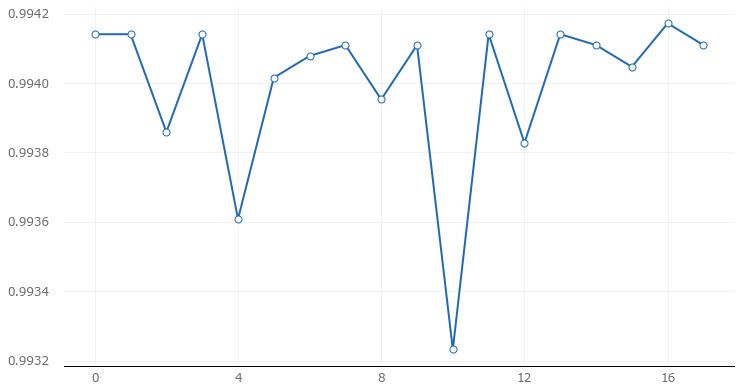

In [57]:
analyze_object.plot_line('val_accuracy')

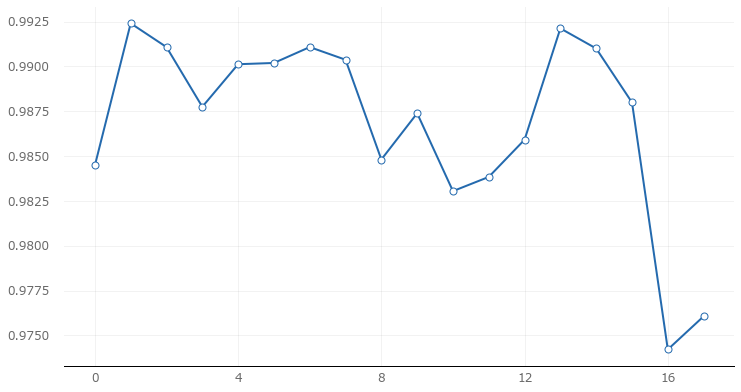

In [58]:
analyze_object.plot_line('accuracy')

#### Training Model with Best Parameters

LSTM

In [62]:
inp=Input(shape=(maxpadlen, ),dtype='int32')

In [63]:
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim_fasttext,
                           weights = [embedding_matrix_fasttext],
                           input_length = maxpadlen,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(inp)

In [64]:
x = LSTM(40, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(30, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.1)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

In [65]:
model_1 = Model(inputs=inp, outputs=preds)
model_1.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [66]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embeddings (Embedding)      (None, 200, 300)          44675400  
                                                                 
 lstm_layer (LSTM)           (None, 200, 40)           54560     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 40)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
                                                                 
 dense_3 (Dense)             (None, 30)                1230      
                                                           

In [67]:
model_info_1=model_1.fit(x_train,y_train, epochs=2, batch_size=32,  validation_data=(x_val, y_val))

Epoch 1/2
3990/3990 [==============================] - 633s 158ms/step - loss: 0.0699 - accuracy: 0.9030 - val_loss: 0.0511 - val_accuracy: 0.9939
Epoch 2/2
3990/3990 [==============================] - 527s 132ms/step - loss: 0.0509 - accuracy: 0.9813 - val_loss: 0.0478 - val_accuracy: 0.9941


## Plotting Graphs

### LSTM

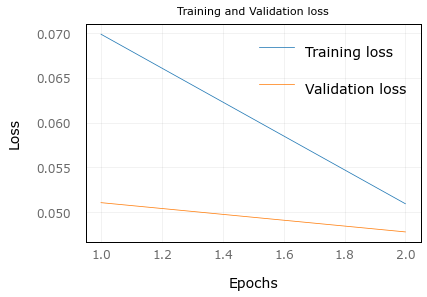

In [68]:
loss = model_info_1.history['loss']
val_loss = model_info_1.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

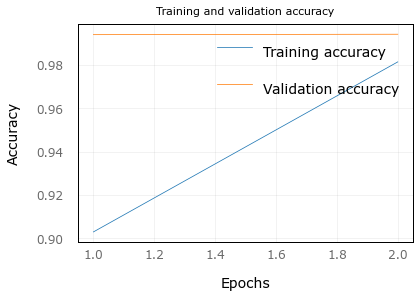

In [69]:
accuracy = model_info_1.history['accuracy']
val_accuracy = model_info_1.history['val_accuracy']

plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();

# Saving the Model

In [70]:
model_1.save(filepath="./saved_models/lstm_toxic")

INFO:tensorflow:Assets written to: ./saved_models/lstm_toxic\assets


INFO:tensorflow:Assets written to: ./saved_models/lstm_toxic\assets


# Loading Saved Model

In [71]:
loaded_model_1 = keras.models.load_model(filepath="./saved_models/lstm_toxic")

# Generating the Output

### LSTM

In [72]:
test_values_1 = loaded_model_1.predict([X_te], batch_size=1, verbose=1)

153164/153164 [==============================] - 1807s 12ms/step


In [78]:
sample_submission = pd.read_csv('./datasetToxic - copy/sample_submission.csv.zip')
test_values_1=pd.DataFrame(test_values_1,columns=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
submission = pd.DataFrame(sample_submission["id"])
combined_submission=pd.concat([submission,test_values_1],axis=1)
combined_submission.to_csv('./datasetToxic - copy/combined_submission_dataframe_csv', index=False)

# Testing the Created Model

In [86]:
def toxicity_level(string):
    new_string = [string]
    new_string = tokenizer.texts_to_sequences(new_string
                                             )
    new_string = pad_sequences(new_string, maxlen=maxpadlen, padding='post')
    
    prediction = model_1.predict(new_string)
    
    
    print("Toxicity levels for '{}':".format(string))
    print('Toxic:         {:.0%}'.format(prediction[0][0]))
    print('Severe Toxic:  {:.0%}'.format(prediction[0][1]))
    print('Obscene:       {:.0%}'.format(prediction[0][2]))
    print('Threat:        {:.0%}'.format(prediction[0][3]))
    print('Insult:        {:.0%}'.format(prediction[0][4]))
    print('Identity Hate: {:.0%}'.format(prediction[0][5]))
    print()
    
    return

In [93]:
toxicity_level('fuck off you dumb idiot')

1/1 [==============================] - 0s 61ms/step
Toxicity levels for 'fuck off you dumb idiot':
Toxic:         100%
Severe Toxic:  37%
Obscene:       97%
Threat:        2%
Insult:        85%
Identity Hate: 2%



In [94]:
toxicity_level('you are such a idiot')

1/1 [==============================] - 0s 75ms/step
Toxicity levels for 'you are such a idiot':
Toxic:         81%
Severe Toxic:  1%
Obscene:       31%
Threat:        1%
Insult:        45%
Identity Hate: 1%



In [95]:
toxicity_level('good morning')

1/1 [==============================] - 0s 64ms/step
Toxicity levels for 'good morning':
Toxic:         1%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%



In [90]:
toxicity_level('fuck ofF!!')

1/1 [==============================] - 0s 63ms/step
Toxicity levels for 'fuck ofF!!':
Toxic:         99%
Severe Toxic:  28%
Obscene:       96%
Threat:        2%
Insult:        73%
Identity Hate: 1%



In [91]:
toxicity_level('Hello, How are you?')

1/1 [==============================] - 0s 48ms/step
Toxicity levels for 'Hello, How are you?':
Toxic:         1%
Severe Toxic:  0%
Obscene:       0%
Threat:        0%
Insult:        0%
Identity Hate: 0%



In [96]:
toxicity_level('fuck off @sshole!!')

1/1 [==============================] - 0s 62ms/step
Toxicity levels for 'fuck off @sshole!!':
Toxic:         99%
Severe Toxic:  28%
Obscene:       96%
Threat:        2%
Insult:        73%
Identity Hate: 1%

